In [1]:
import numpy as np
import matplotlib.pyplot as plt

Notation:
- X is the domain. This is discretised for the sake of plotting
- $\mu_{domain}$ is just the prior mean. This is set to 0 for the sake of demonstration

In [2]:
X_domain = np.linspace(0, 10, 101)
mu_domain = np.zeros_like(X_domain)


The kernel determines the covariance matrix in place. The kernel below is the squared exponential kernel; that is:
$$
k(x_i, x_j) = \sigma * e^{-\frac{\vert x_i - x_j \vert^2}{l ^ 2}}
$$

, Parameterised by the standard deviation $\sigma$ and the length scale $l$

In [3]:
def squared_exponential_kernel(x1, x2, length_scale=1, stdev=1):
    sq_distance = (x1[:, None] - x2[None, :]) ** 2 # This just broadcasts when two vectors are the inputs

    return stdev * np.exp(-0.5 * sq_distance/(length_scale ** 2))

In [4]:
K = squared_exponential_kernel(X_domain, X_domain)

In [5]:
realisations = []

for _ in range(100):
    sample = np.random.multivariate_normal(mean = mu_domain, cov=K)
    realisations.append(sample)

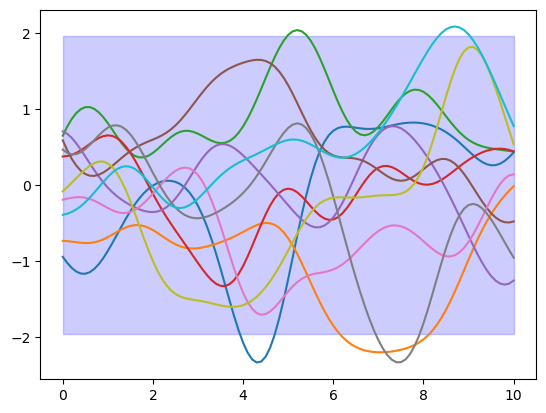

In [6]:
# Plot the realisations
for item in realisations[:10]:
    plt.plot(X_domain, item)

# plot the credible intervals
std_error = np.diag(K)
plt.fill_between(X_domain, mu_domain - 1.96 * std_error, mu_domain + 1.96 * std_error, color = 'blue', alpha=0.2)

plt.show()

In [7]:
# Check validity of credible intervals
realisations = np.array(realisations)
np.sum(np.where(np.abs(realisations) < 1.96))/10**6

np.float64(0.954001)

Now, the process for updating conducting a Bayesian update on a GP

First, some machinery is introduced.

Given two sets of random variables $X_1 ...., X_q$ and $X_{q+1}, ..... X_p$, with:

$$
X = 
\begin{pmatrix}
X^{(1)} \\
X^{(2)}
\end{pmatrix}
=
\begin{pmatrix}
X_1 \\
\vdots \\
X_q \\
X_{q+1} \\
\vdots \\
X_p
\end{pmatrix}
$$

, such that $X^{(1)} \sim \mathcal{N}(\boldsymbol{\mu ^ {(1)}}, \boldsymbol{\Sigma_{11})}$, and $X^{(2)} \sim \mathcal{N}(\boldsymbol{\mu ^ {(2)}}, \boldsymbol{\Sigma_{22})}$, and $Cov(X^{(1)}, X^{(2)}) = \boldsymbol{\Sigma_{12}}$

If $\boldsymbol{\Sigma_{12}} = 0$, then $X^{(1)} \text{ and } X^{(2)}$ are uncorrelated, and the marginal distribution of $X_i$ is just a normal distribution with mean $\boldsymbol{\mu_i} \text{ and covariance } \boldsymbol{\Sigma_{ii}}$. This seems reasonable.

This can be extended for correlated $X^{(1)} \text{and} X^{(2)}$. Particularly, introducing $Y^{(1)} \text{ and } Y^{(2)}$ such that $Y^{(1)} \text{ and } Y^{(2)}$ and uncorrelated by choosing a suitable B in:

$$
Y^{(1)} = X^{(1)} + BX^{(2)}, Y^{(2)} = X^{(2)}
$$

Can solve for $B$ in:

$$
\mathbf{0} = \mathbb{E}(Y^{(1)} - \mathbb{E}Y^{(1)})(Y^{(2)} - \mathbb{E}Y^{(2)})
$$



$$
= \mathbb{E}(X^{(1)} + B X^{(2)} - \mathbb{E}X^{(1)} - B \mathbb{E}X^{(2)})(X^{(2)} - \mathbb{E}X^{(2)})'
$$

$$
= \mathbb{E}[(X^{(1)} - \mathbb{E}X^{(1)}) + B(X^{(2)} - \mathbb{E}X^{(2)})](X^{(2)} - \mathbb{E}X^{(2)})'
$$

$$
= \Sigma_{12} + B \Sigma_{22}.
$$

, so $B = -\boldsymbol{\Sigma_{12}}\boldsymbol{\Sigma_{22}}^{-1}$

Now, we can solve for the distribution of $Y$

$$
\mathbb{E}\!\begin{pmatrix} Y^{(1)} \\ Y^{(2)} \end{pmatrix}
= \mathbb{E}\!\begin{pmatrix} I & -\Sigma_{12}\Sigma_{22}^{-1} \\ 0 & I \end{pmatrix} X
$$

$$
= \begin{pmatrix} I & -\Sigma_{12}\Sigma_{22}^{-1} \\ 0 & I \end{pmatrix}
\begin{pmatrix} \mu^{(1)} \\ \mu^{(2)} \end{pmatrix}
$$

$$
= \begin{pmatrix} \mu^{(1)} - \Sigma_{12}\Sigma_{22}^{-1}\mu^{(2)} \\ \mu^{(2)} \end{pmatrix}
= \begin{pmatrix} \nu^{(1)} \\ \nu^{(2)} \end{pmatrix}
= \nu
$$

, and Covariance given by:

$$
\mathbb{E}(Y - \nu)(Y - \nu)' 
= \begin{pmatrix} 
\mathbb{E}(Y^{(1)} - \nu^{(1)})(Y^{(1)} - \nu^{(1)})' & \mathbb{E}(Y^{(1)} - \nu^{(1)})(Y^{(2)} - \nu^{(2)})' \\
\mathbb{E}(Y^{(2)} - \nu^{(2)})(Y^{(1)} - \nu^{(1)})' & \mathbb{E}(Y^{(2)} - \nu^{(2)})(Y^{(2)} - \nu^{(2)})'
\end{pmatrix}
$$

$$
= \begin{pmatrix} 
\Sigma_{11} - \Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21} & 0 \\
0 & \Sigma_{22} 
\end{pmatrix}
$$


As $Y^{(1)} \text{ and } Y^{(2)}$ are uncorrelated, the joint pdf is given by:
$$
n\!\big(y^{(1)} \mid \mu^{(1)} - \Sigma_{12}\Sigma_{22}^{-1}\mu^{(2)},\;
\Sigma_{11} - \Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21}\big)\;
n\!\big(y^{(2)} \mid \mu^{(2)},\; \Sigma_{22}\big)
$$

Want to reformulate wrt $x$. Particularly, $Y^{(1)}$ is $X^{(1)} - \Sigma_{12}\Sigma_{22}^{-1}X^{(2)}$, so $X^{(1)}$ = $Y^{(1)} + \Sigma_{12}\Sigma_{22}^{-1}X^{(2)}$

Given the independence established previously, conditioning on $X^{(2)} = x^{(2)}$, and taking the expectation of $X^{(1)}$, we have:

$$
E(X^{(1)}) = \mu^{(1)} + \Sigma_{12}\Sigma_{22}^{-1}(x^{(2)} - \mu^{(2)})
$$

, and the covariance is independent of the realisation of $x^{(2)}$ in this parameterisation. This procedure for determining the posterior can be applied to Bayesian optimisation

Considering a desire to optimise an objective function, modelled as some Gaussian process. Observations are drawn as $y = f(x) + \epsilon$

Given some observation locations ${x_i}$ and observation values ${y_i}$, we desire to determine the posterior $p(f \vert \mathbf{y})$

First, we create the joint $p(f, \mathbf{y})$ as a Gaussian process. The mean of $\begin{bmatrix} f \\ \mathbf{y} \end{bmatrix} $ is just $\begin{bmatrix} \boldsymbol{\mu} \\ \mathbf{m} \end{bmatrix} $, where $\boldsymbol{\mu}$ is just the prior mean on $f$, and $\boldsymbol{m}$ is the mean of at the observation points.

Determining the covariance matrix present here is slightly more involed. We construct it in block matrix form, with the following:

1) K is the kernel applied to the domain X; K = k(X, X)
2) $\kappa$ is the kernel applied to the domain and the observation points. $k(f(x_i), y_j) = k(f(x_i), f(x_j) + \epsilon_j) = k(f(x_i), f(x_j)) + k(f(x_i), \epsilon_j)$. With the assumption that $\epsilon_i$ is i.i.d normal with $\epsilon_j \sim \mathcal{N}(0, \sigma^2)$, this just becomes k(X, X_{obs})
3) C is the kernel applied to all pairs of observation points. $k(y_i, y_j) = k(f(x_i) + \epsilon_i, f(x_j) + \epsilon_j) = k(f(x_i), f(x_j)) + k(f(x_i), \epsilon_j) + k(\epsilon_i, f(x_j)) + k(\epsilon_i, \epsilon_j)$. Given our assumptions on $\epsilon$, this is just $k(X_{obs}, X_{obs}) + \sigma^2I$

Therefore, can specify that:

$$
p(f, y) \;=\; \mathcal{GP}\!\left(
\begin{bmatrix}
f \\[6pt]
y
\end{bmatrix}
;\;
\begin{bmatrix}
\mu \\[6pt]
m
\end{bmatrix},
\begin{bmatrix}
K & \kappa^\top \\[6pt]
\kappa & C
\end{bmatrix}
\right)
$$

Applying the previous conditioning rule to this, we get:

$$
p(f \vert \boldsymbol{y}) = \mathcal{GP}(f; \mu_D, K_D)
$$

where, 

$$
\mu_D(x) = \mu(x) + \kappa(x)^\top C^{-1}(y - m)
$$

$$
K_D(x, x') = K(x, x') - \kappa(x)^\top C^{-1}\kappa(x')
$$

Below, an implementation of this is found:

In [28]:
X_obs = np.linspace(0, 10, 11)
mu_obs = np.zeros_like(X_obs)

sigma = 0.2

C = squared_exponential_kernel(X_obs, X_obs) + np.diag(np.full(len(X_obs), sigma**2))

k = squared_exponential_kernel(X_obs, X_domain)

In [29]:
sample = np.random.multivariate_normal(mu_obs, C)

In [30]:
mu_posterior = mu_domain + k.T @ np.linalg.inv(C) @ (sample - mu_obs)
cov_posterior = K - k.T @ np.linalg.inv(C) @ k

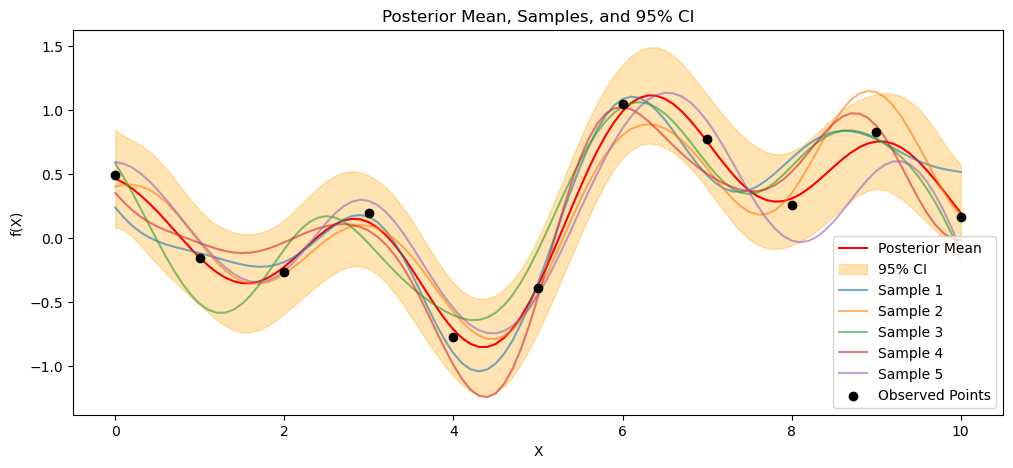

In [33]:
plt.figure(figsize = (12, 5))
plt.plot(X_domain, mu_posterior, label="Posterior Mean", color="red")

# 95% confidence interval
std_posterior = np.sqrt(np.diag(cov_posterior))
plt.fill_between(
    X_domain,
    mu_posterior - 1.96 * std_posterior,
    mu_posterior + 1.96 * std_posterior,
    color="orange",
    alpha=0.3,
    label="95% CI"
)

# Draw samples from the posterior
posterior_samples = np.random.multivariate_normal(mu_posterior, cov_posterior, size=5)
for i, posterior_sample in enumerate(posterior_samples):
    plt.plot(X_domain, posterior_sample, alpha=0.6, label=f"Sample {i+1}")

# Plot observed points (the actual sample from earlier)
plt.scatter(X_obs, sample, color="black", zorder=5, label="Observed Points")

plt.xlabel("X")
plt.ylabel("f(X)")
plt.title("Posterior Mean, Samples, and 95% CI")
plt.legend()
plt.show()

We can now perform updates in response to new observations. The next challenge is the acquisition function determining which points to observe next.